# **Reviewing Learning Curves**

**Learning objectives**

1. Build and train a Keras Sequential model
2. Specify various learning rates to a model
3. Visualise the loss curves

## **Introduction**

In this notebook, you will observe learning curves changes. You will use the Keras Sequential model to build an ML model to predict housing prices.

A learning curve is a plot of model learning performance over experience or time.

Learning curves are a widely used diagnostic tool in ML for algorithms that learn from a training data set incrementally. The model can be evaluated on the training data set and on a hold out validation data set after each update during training, and plots of the measured performance can be created to show learning curves. Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation data sets are suitably representative.

Adam is an optimisation algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data. cf. [How to use Learning Curves to Diagnose ML Model Performance](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

Start by importing the necessary libraries for this lab.

In [1]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.4.1


### **Load data set**

Many of the Google ML courses programming exercises use the [California Housing Data Set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), which contains data drawn from the 1990 U.S. census

In [27]:
!head {path+filename}

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY
-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


In [40]:
path = "/home/antounes/Documents/tensorflow/data/"

# Read `housing.csv` file using the `read_csv()` function included in the Pandas library
filename = "housing.csv"
housing_df = pd.read_csv(path+filename, error_bad_lines=False)
housing_df = housing_df[~housing_df["total_bedrooms"].isnull()]
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can use `.describe()` to see some summary statistics for the numeric fields in our DataFrame. Note, for example, the count row and corresponding columns. The count shows `20433.000000` for all feature columns. Thus, there are no missing values.

In [42]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### **Split data set for ML**

The data set we loaded was a single CSV file. We will split this into train, validation, and test sets.

In [45]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# Let's output the count of `train`, `val`, and `test`
print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

# The `.to_csv()` method will write object to a CSV file
train.to_csv(path+"housing-train.csv", encoding="utf-8", index=False)
val.to_csv(path+"housing-val.csv", encoding="utf-8", index=False)
test.to_csv(path+"housing-test.csv", encoding="utf-8", index=False)

13076 train examples
3270 validation examples
4087 test examples


In [48]:
# A utility method to create a `tf.data.Dataset` from a Pandas DataFrame

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop("median_house_value")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Next we initialise the training and validation data sets
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

# Input pipeline
numeric_cols = ["longitude", "latitude", "housing_median_age", "total_rooms",
                "total_bedrooms", "population", "households", "median_income"]

# Next, we scale the numerical feature columns that we assigned to the variable `numeric_cols`
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(tf.feature_column.numeric_column(header, normalizer_fn = scal_input_fn))

## **Using the Keras Sequential Model**

Next, we will run this cell to compile and fit the Keras Sequential model

### **Model 1 $-$ Hard coding the learning rate to `0.5`**

In [50]:
# Create model

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype="float64")

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(12, input_dim=8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear", name="median_house_value")
])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.5)
model.compile(optimizer=opt,
              loss="mse",
              metrics=["mse"])

# Train model
# Using the `.fit()` method we can train our model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
408/409 [============================>.] - ETA: 0s - loss: 19013392865.8824 - mse: 19013392865.8824WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

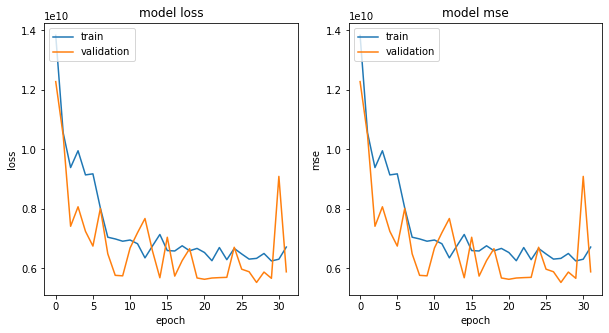

In [51]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    # Using the `.figure()` method we can create a new figure or activate an existing figure
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        # Using the `.add_subplot()` method we can add a subplot to the current figure
        ax = fig.add_subplot(nrows, ncols, idx+1)
        # The `.plot()` is a versatile function and will take an arbitrary number of arguments
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        # Using the `.legend()` method we can place a legend on the axes
        plt.legend(["train", "validation"], loc="upper left");

plot_curves(history, ["loss", "mse"])

### **Model 2 $-$ Hard coding the learning rate to `0.1`**

In [56]:
# Create model
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype="float64")

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(12, input_dim=8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear", name="median_house_value")
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss="mse",
              metrics=["mse"])

# Train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
393/409 [===========================>..] - ETA: 0s - loss: 24410144825.3232 - mse: 24410144825.3232WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

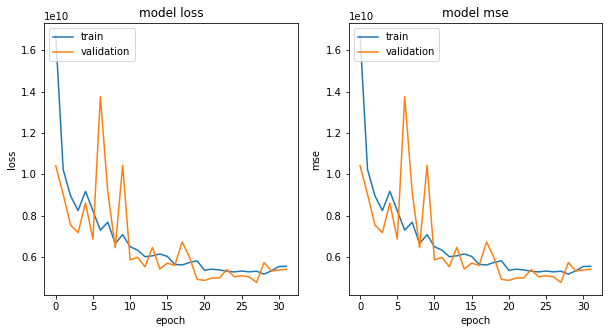

In [57]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");
        
plot_curves(history, ["loss", "mse"])

### **Model 3 $-$ Hard coding the learning rate to `0.1`**

In [60]:
# Create model

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype="float64")

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(12, input_dim=8, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="linear", name="median_house_value")
])

# Compile model

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss="mse",
              metrics=["mse"])

# Train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
408/409 [============================>.] - ETA: 0s - loss: 37637091975.5294 - mse: 37637091975.5294WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

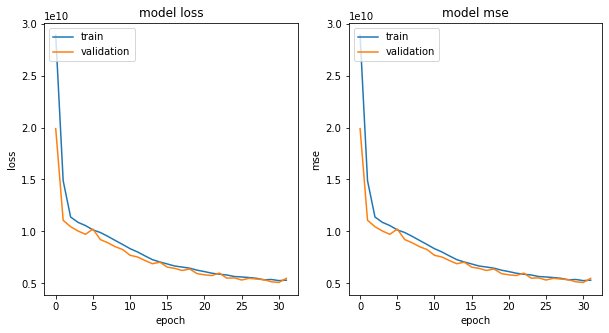

In [61]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");
        
plot_curves(history, ["loss", "mse"])

### **Model 4 $-$ Hard coding the learning rate to `0.001`**

In [62]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype="float64")

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(12, input_dim=8, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear", name="median_house_value")
])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss="mse",
              metrics=["mse"])

# Train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
400/409 [============================>.] - ETA: 0s - loss: 54027502110.7200 - mse: 54027502110.7200WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

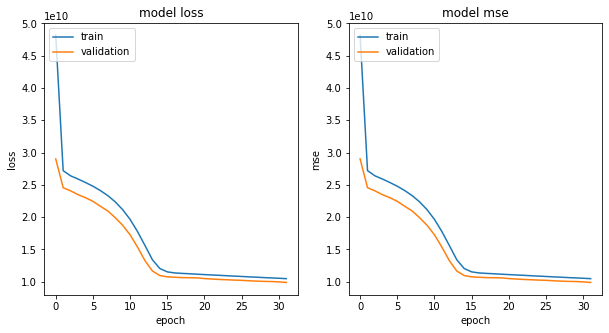

In [64]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");
        
plot_curves(history, ["loss", "mse"])